In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Flatten, Input, Attention
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras import backend as K
from xgboost import XGBRegressor
from keras.regularizers import l2, l1
from scipy.stats import pearsonr, spearmanr
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor
import shap
import seaborn as sns

### UTILITY FUNCTIONS

In [1]:
IBM_BLUE = "#648FFF"
IBM_PURPLE = "#785EF0"
IBM_PINK = "#DC267F"
IBM_ORANGE = "#FE6100"
IBM_YELLOW = "#FFB000"

In [154]:
# Define the columns for each normalization
flow_columns = ['conchos_flow', 'alv_flow']
storage_columns = ['lb_storage', 'ami_storage']
flood_columns = ['lb_flood', 'ami_flood', 'falc_flood']
static_columns = ['ami_conservation','falc_conservation','lb_conservation',
                    'ami_dead','lb_dead','falc_dead']  # Assuming no static characteristics for now
precip_columns = ['precipitation','tc']
deliveries_column = 'deliveries'  # Specify the target variable for deliveries

In [3]:
### IBWC file reader
def clean_IBWC_csvs(path,dropcols='End of Interval (UTC-06:00)',value_current="Average (TCM)",skiphead=4,skipfoot=1,
                    value_target="storage",datecol="Start of Interval (UTC-06:00)",start_date='1962-01-01',end_date='2023-12-31'):
    """
    Cleans a csv dataset from the IBWC
    """
    dat = pd.read_csv(path,skiprows=skiphead,skipfooter=skipfoot,engine='python')
    try:
        dat.drop(dropcols, inplace=True, axis='columns')
    except:
        print(f'No columns to drop, continuing...')
    dat[datecol] = pd.to_datetime(dat[datecol])
    dat.rename(columns={datecol:"date", value_current:value_target}, inplace=True)
    dat["date"] = pd.to_datetime(dat["date"])
    dat = dat[(dat['date'] >= start_date) & (dat['date'] <= end_date)]
    return dat

In [219]:
def clean_daymet_data(path,skiphead=6,start_date='1962-01-01',end_date='2023-12-31'):
    dat = pd.read_csv(path,skiprows=skiphead,engine='python')
    dat['date'] = pd.to_datetime(dat['year'].astype(str) + dat['yday'].astype(int).astype(str), format='%Y%j')
    print(dat.columns)
    dat = dat[(dat['date'] >= start_date) & (dat['date'] <= end_date)]
    dat = dat.drop(['yday','year','dayl (s)'],axis='columns')
    return dat

In [220]:
clean_daymet_data("/Users/laratobias-tarsh/Documents/SEAS_hydro/deliveries/daymet_data/daymet_conchos.csv")

Index(['year', 'yday', 'dayl (s)', 'prcp (mm/day)', 'srad (W/m^2)',
       'swe (kg/m^2)', 'tmax (deg c)', 'tmin (deg c)', 'vp (Pa)', 'date'],
      dtype='object')


,prcp (mm/day),srad (W/m^2),swe (kg/m^2),tmax (deg c),tmin (deg c),vp (Pa),date
0,0.00,342.70,0.0,20.35,-1.45,381.22,1980-01-01
1,0.00,351.36,0.0,21.47,-1.45,369.43,1980-01-02
2,0.00,273.41,0.0,15.64,0.56,528.92,1980-01-03
3,0.00,367.83,0.0,21.83,-3.37,308.82,1980-01-04
4,0.00,347.27,0.0,20.86,-1.12,383.39,1980-01-05
...,...,...,...,...,...,...,...
14960,0.00,372.43,0.0,20.80,-6.88,122.81,2020-12-26
14961,0.00,360.90,0.0,23.85,-1.74,185.81,2020-12-27
14962,0.00,358.12,0.0,23.71,-1.36,191.48,2020-12-28
14963,0.00,349.80,0.0,27.62,3.51,278.69,2020-12-29


In [4]:
def normalize_data(df, flow_columns, storage_columns, flood_columns, static_columns, precip_columns, deliveries_column=None):
    """
    Normalize the dataframe with the following steps:
    1. Min-Max scaling for flow variables.
    2. Normalize storage relative to flood capacity.
    3. Standardize precipitation and other continuous features.
    4. Normalize deliveries (target variable) if provided.

    Also, returns the necessary values for later denormalization (scalers, flood capacities).

    Parameters:
    df (pd.DataFrame): The input dataframe containing raw data.
    flow_columns (list): List of columns for flow variables to be normalized.
    storage_columns (list): List of columns for storage variables to be normalized.
    flood_columns (list): List of columns for flood capacity for each reservoir.
    static_columns (list): List of columns for static reservoir characteristics to be normalized.
    precip_columns (list): List of columns for precipitation and other continuous variables to be standardized.
    deliveries_column (str, optional): The column for target variable deliveries to be normalized.

    Returns:
    pd.DataFrame: The normalized dataframe.
    dict: A dictionary containing values needed for denormalization (scalers, flood capacities).
    """
    # --- Flow normalization (Min-Max Scaling) ---
    flow_scaler = MinMaxScaler()
    df[flow_columns] = flow_scaler.fit_transform(df[flow_columns])

    # --- Storage normalization (relative to flood capacity) ---
    flood_capacities = {col: df[col].copy() for col in flood_columns}

    # Normalize storage by dividing by flood capacity
    for storage_col, flood_col in zip(storage_columns, flood_columns):
        df[storage_col] = df[storage_col] / df[flood_col]

    # --- Static reservoir characteristics normalization (relative to flood capacity) ---
    for col in static_columns:
        reservoir_prefix = col.split('_')[0]
        df[col] = df[col] / df[f'{reservoir_prefix}_flood']  # Normalize by flood capacity

    # --- Set flood columns to 1 (as the reference) ---
    for flood_col in flood_columns:
        df[flood_col] = 1  # Set flood capacity to 1 for all rows

    # --- Precipitation and other continuous variables (Standardization) ---
    std_scaler = StandardScaler()
    df[precip_columns] = std_scaler.fit_transform(df[precip_columns])

    # --- Normalize Deliveries (target variable) if provided ---
    deliveries_scaler = None
    if deliveries_column:
        deliveries_scaler = MinMaxScaler()  # or StandardScaler() depending on your preference
        df[deliveries_column] = deliveries_scaler.fit_transform(df[[deliveries_column]])

    # Prepare the dictionary for denormalization
    denormalization_info = {
        'flow_scaler': flow_scaler,
        'flood_capacities': flood_capacities,
        'std_scaler': std_scaler,
        'deliveries_scaler': deliveries_scaler
    }

    return df, denormalization_info



In [5]:
def denormalize(normalized_deliveries, denormalization_info):
    """
    Denormalize the deliveries column based on the scaler information.
    
    Parameters:
    normalized_deliveries (array-like): The normalized deliveries to be denormalized.
    denormalization_info (dict): The dictionary containing the scaler for deliveries.
    
    Returns:
    array: The denormalized deliveries values.
    """
    deliveries_scaler = denormalization_info.get('deliveries_scaler')
    if deliveries_scaler is None:
        raise ValueError("No scaler found for deliveries in denormalization_info.")
    
    # Reshape to 2D as required by the scaler
    normalized_deliveries = normalized_deliveries.reshape(-1, 1)
    
    # Denormalize deliveries
    denormalized_deliveries = deliveries_scaler.inverse_transform(normalized_deliveries)
    
    return denormalized_deliveries


In [53]:
def process_data(df, target_column='flow', lookback_period=100, lag_dict=None, debug=0, trainyrs=5, valyrs=3):
    if debug < 1:
        print("Initial Data:")
        print(df.head())

    data = df.copy()
    data, denorm = normalize_data(data,flow_columns, storage_columns, flood_columns, static_columns, precip_columns, deliveries_column)

    # Ensure the date column is datetime
    data['date'] = pd.to_datetime(data['date'])
  
    for var, lag in lag_dict.items():
        if isinstance(lag,int):
            for i in range(1, lag + 1):
                data[f'{var}_lag{i}'] = data[var].shift(i)
        else:
            for i in lag:
                data[f'{var}_lag{i}'] = data[var].shift(i)

    # Drop rows with NaN values due to lagging
    data = data.dropna()

    # Select features dynamically based on the lag_dict
    feature_columns = []
    for var, lag in lag_dict.items():
        if isinstance(lag,int):
            feature_columns.extend([f'{var}_lag{i}' for i in range(1, lag + 1)])
        else:
            feature_columns.extend([f'{var}_lag{i}' for i in lag])

    if debug > 1:
        print("\nFeature Columns Selected:")
        print(feature_columns)

    # Define the features and target (y)
    features = data[feature_columns]
    target = data[target_column]

    if debug > 1:
        print("\nFeatures DataFrame:")
        print(features.head())
        
        print("\nTarget Series:")
        print(target.head())

    # Normalize dynamic features
    feature_means = features.mean(axis=0)
    feature_stds = features.std(axis=0)
    features_scaled = (features - feature_means) / feature_stds

    # Normalize target variable
    target_mean = target.mean()
    target_std = target.std()
    target_scaled = (target - target_mean) / target_std

    if debug > 1:
        print("\nNormalized Features DataFrame:")
        print(features_scaled.head())
        
        print("\nNormalized Target Series:")
        print(target_scaled.head())

    # Convert to numpy arrays
    features_scaled = features.values
    target_scaled = target.values

    X = []
    y = []

    for i in range(lookback_period, len(features_scaled)):
        X.append(features_scaled[i-lookback_period:i])
        y.append(target_scaled[i])

    X = np.array(X)
    y = np.array(y)

    # Define the indices for the desired train/val/test period
    start_date = data['date'].iloc[0]
    train_end_date = start_date + timedelta(days=365.25*trainyrs)
    val_end_date = train_end_date + timedelta(days=365.25*valyrs)

    train_end_index = data[data['date'] <= train_end_date].index[-1] - lookback_period + 1
    val_end_index = data[data['date'] <= val_end_date].index[-1] - lookback_period + 1

    X_train, X_val, X_test = X[:train_end_index], X[train_end_index:val_end_index], X[val_end_index:]
    y_train, y_val, y_test = y[:train_end_index], y[train_end_index:val_end_index], y[val_end_index:]

    # Extract dates for train, validation, and test sets
    train_dates = data['date'].iloc[:train_end_index + lookback_period]
    val_dates = data['date'].iloc[train_end_index + lookback_period:val_end_index + lookback_period]
    test_dates = data['date'].iloc[val_end_index + lookback_period:]

    dates_dict = {
        'train_dates': train_dates,
        'val_dates': val_dates,
        'test_dates': test_dates
    }

    if debug > 1:
        print("\nFirst 5 rows of Training Data (X_train):")
        print(X_train[:5])
        print("\nFirst 5 rows of Training Targets (y_train):")
        print(y_train[:5])

        print("\nTraining Date Range:")
        print(train_dates.iloc[0], "to", train_dates.iloc[-1])

        print("\nValidation Date Range:")
        print(val_dates.iloc[0], "to", val_dates.iloc[-1])

        print("\nTest Date Range:")
        print(test_dates.iloc[0], "to", test_dates.iloc[-1])

    return X_train, X_val, X_test, y_train, y_val, y_test, denorm, dates_dict, feature_columns

In [47]:
def process_data_for_xgboost(df, target_column='flow', lag_dict=None, debug=0, trainyrs=5, valyrs=3):
    # Ensure the date column is datetime
    df['date'] = pd.to_datetime(df['date'])

    # Add lagged features dynamically based on the specified lag_dict
    data = df.copy()
    data, denorm = normalize_data(data,flow_columns, storage_columns, flood_columns, static_columns, precip_columns, deliveries_column)

    for var, lag in lag_dict.items():
        if isinstance(lag,int):
            for i in range(1, lag + 1):
                data[f'{var}_lag{i}'] = data[var].shift(i)
        else:
            for i in lag:
                data[f'{var}_lag{i}'] = data[var].shift(i)

    # Drop rows with NaN values due to lagging
    data = data.dropna()

    # Select features dynamically based on the lag_dict
    feature_columns = []
    for var, lag in lag_dict.items():
        if isinstance(lag,int):
            feature_columns.extend([f'{var}_lag{i}' for i in range(1, lag + 1)])
        else:
            feature_columns.extend([f'{var}_lag{i}' for i in lag])

    if debug:
        print("\nFeature Columns Selected:")
        print(feature_columns)

    # Extract features and target
    features = data[feature_columns]
    target = data[target_column]

    # Convert to numpy arrays
    features_scaled = features.values
    target_scaled = target.values

    # Define the indices for the desired train/val/test period
    start_date = data['date'].iloc[0]
    train_end_date = start_date + timedelta(days=365.25 * trainyrs)
    val_end_date = train_end_date + timedelta(days=365.25 * valyrs)

    train_end_index = data[data['date'] <= train_end_date].index[-1]
    val_end_index = data[data['date'] <= val_end_date].index[-1]

    X_train, X_val, X_test = features_scaled[:train_end_index + 1], features_scaled[train_end_index + 1:val_end_index + 1], features_scaled[val_end_index + 1:]
    y_train, y_val, y_test = target_scaled[:train_end_index + 1], target_scaled[train_end_index + 1:val_end_index + 1], target_scaled[val_end_index + 1:]

    # Extract dates for train, validation, and test sets
    train_dates = data['date'][:train_end_index + 1]
    val_dates = data['date'][train_end_index + 1:val_end_index + 1]
    test_dates = data['date'][val_end_index + 1:]


    dates_dict = {
        'train_dates': train_dates,
        'val_dates': val_dates,
        'test_dates': test_dates
    }

    if debug:
        print(f"\nFirst 5 rows of Training Data (X_train):\n{X_train[:5]}")
        print(f"\nFirst 5 rows of Training Targets (y_train):\n{y_train[:5]}")
        print(f"\nTraining Date Range: {train_dates.iloc[0]} to {train_dates.iloc[-1]}")
        print(f"\nValidation Date Range: {val_dates.iloc[0]} to {val_dates.iloc[-1]}")
        print(f"\nTest Date Range: {test_dates.iloc[0]} to {test_dates.iloc[-1]}")

    return X_train, X_val, X_test, y_train, y_val, y_test, denorm, dates_dict, feature_columns

In [8]:
def persistence_model(y_train, y_test):
    # Use the last value of y_train as the persistence prediction for the first value of y_test
    first_prediction = y_train[-1]
    predictions = np.zeros_like(y_test)
    
    # Setting the first prediction
    predictions[0] = first_prediction
    
    # All subsequent predictions use the previous time step value from y_test
    for i in range(1, len(y_test)):
        predictions[i] = y_test[i-1]
    
    return predictions

In [244]:
def nash_sutcliffe_efficiency(observed, predicted):
    return 1 - (np.sum((observed - predicted) ** 2) / np.sum((observed - np.mean(observed)) ** 2))

def kling_gupta_efficiency(observed, predicted):
    cc = np.corrcoef(observed, predicted)[0, 1]
    alpha = np.std(predicted) / np.std(observed)
    beta = np.mean(predicted) / np.mean(observed)
    return 1 - np.sqrt((cc - 1) ** 2 + (alpha - 1) ** 2 + (beta - 1) ** 2)

def rmse_95th_percentile(y_true, y_pred):
    threshold = np.percentile(y_true, 95)
    extreme_indices = y_true > threshold
    if np.sum(extreme_indices) > 0:  # Ensure there are values above the threshold
        return np.sqrt(mean_squared_error(y_true[extreme_indices], y_pred[extreme_indices]))
    else:
        return np.nan  # If no values exceed the threshold, return NaN


In [284]:
def evaluate_persistence_model(y_train, y_test, denorm_dict):
    # Get predictions using persistence model
    predictions = persistence_model(y_train, y_test)
    
    # Denormalize predictions and target
    denorm_predictions = denormalize(predictions.flatten(), denorm_dict).flatten()
    denorm_y_test = denormalize(y_test, denorm_dict).flatten()

    # Calculate metrics
    mae = mean_absolute_error(denorm_y_test, denorm_predictions)
    rmse = np.sqrt(mean_squared_error(denorm_y_test, denorm_predictions))
    pearson_corr, _ = pearsonr(denorm_y_test, denorm_predictions)
    spearman_corr, _ = spearmanr(denorm_y_test, denorm_predictions)
    nse = nash_sutcliffe_efficiency(denorm_y_test, denorm_predictions)
    kge = kling_gupta_efficiency(denorm_y_test, denorm_predictions)
    
    # Collect metrics in a dictionary
    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'Pearson_Correlation': pearson_corr,
        'Spearman_Correlation': spearman_corr,
        'Nash_Sutcliffe_Efficiency': nse,
        'Kling_Gupta_Efficiency': kge,
    }
    
    return denorm_predictions, denorm_y_test, metrics

In [285]:
def train_evaluate_xgboost_model(model, X_train, y_train, X_val, y_val, X_test, y_test, denorm_dict, n_estimators=1000, early_stopping_rounds=10):
    # Train model
    history = model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=False)
    
    # Evaluate model
    predictions = model.predict(X_test)
    
    # Denormalize predictions and target
    denorm_predictions = denormalize(predictions.flatten(), denorm_dict).flatten()
    denorm_y_test = denormalize(y_test, denorm_dict).flatten()
    
    # Calculate metrics
    mae = mean_absolute_error(denorm_y_test, denorm_predictions)
    rmse = np.sqrt(mean_squared_error(denorm_y_test, denorm_predictions))
    pearson_corr, _ = pearsonr(denorm_y_test, denorm_predictions)
    spearman_corr, _ = spearmanr(denorm_y_test, denorm_predictions)
    nse = nash_sutcliffe_efficiency(denorm_y_test, denorm_predictions)
    kge = kling_gupta_efficiency(denorm_y_test, denorm_predictions)
    
    # Collect metrics in a dictionary
    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'Pearson_Correlation': pearson_corr,
        'Spearman_Correlation': spearman_corr,
        'Nash_Sutcliffe_Efficiency': nse,
        'Kling_Gupta_Efficiency': kge,
    }
    
    return model, denorm_predictions, denorm_y_test, metrics

In [286]:
def evaluate_rf_model(model, X_train, y_train, X_val, y_val, X_test, y_test, denorm_dict):
    # Train model
    model.fit(X_train, y_train)
    
    # Predict on the test set
    predictions = model.predict(X_test)
    
    # Denormalize predictions and target
    denorm_predictions = denormalize(predictions.flatten(), denorm_dict).flatten()
    denorm_y_test = denormalize(y_test, denorm_dict).flatten()

    # Calculate metrics
    mae = mean_absolute_error(denorm_y_test, denorm_predictions)
    rmse = np.sqrt(mean_squared_error(denorm_y_test, denorm_predictions))
    pearson_corr, _ = pearsonr(denorm_y_test, denorm_predictions)
    spearman_corr, _ = spearmanr(denorm_y_test, denorm_predictions)
    nse = nash_sutcliffe_efficiency(denorm_y_test, denorm_predictions)
    kge = kling_gupta_efficiency(denorm_y_test, denorm_predictions)
    
    # Collect metrics in a dictionary
    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'Pearson_Correlation': pearson_corr,
        'Spearman_Correlation': spearman_corr,
        'Nash_Sutcliffe_Efficiency': nse,
        'Kling_Gupta_Efficiency': kge,
    }
    
    return model, denorm_predictions, denorm_y_test, metrics

In [254]:
### Model Training and Evaluation Functions
def train_evaluate_sequential(model, X_train, y_train, X_val, y_val, X_test, y_test, denorm_dict, epochs=30, batch_size=32,train=True):
    # Train model
    if train:
        history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val), verbose=0)
    
    # Evaluate model
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    predictions = model.predict(X_test)
    
    # Denormalize predictions and target
    denorm_predictions = denormalize(predictions.flatten(), denorm_dict)
    denorm_y_test = denormalize(y_test, denorm_dict)
    
    # Calculate metrics
    mae = mean_absolute_error(denorm_y_test, denorm_predictions)
    rmse = np.sqrt(mean_squared_error(denorm_y_test, denorm_predictions))
    pearson_corr, _ = pearsonr(denorm_y_test, denorm_predictions)
    spearman_corr, _ = spearmanr(denorm_y_test, denorm_predictions)
    nse = nash_sutcliffe_efficiency(denorm_y_test, denorm_predictions)
    #kge = kling_gupta_efficiency(denorm_y_test, denorm_predictions)
    rmse_extreme = rmse_95th_percentile(denorm_y_test, denorm_predictions)

    metrics = {
        'MAE': mae,
        'RMSE': rmse,
        'Pearson_Correlation': pearson_corr,
        'Spearman_Correlation': spearman_corr,
        'Nash_Sutcliffe_Efficiency': nse,
        #'Kling_Gupta_Efficiency': kge,
        'RMSE_Extreme': rmse_extreme
    }
    
    
    return model, denorm_predictions, denorm_predictions, denorm_y_test, metrics

In [15]:
def integrated_gradients(model, X_input, baseline=None, num_steps=50):
    """
    Compute integrated gradients for a given model and input.
    Aggregates importance across all time steps to get per-feature importance.

    Parameters:
    - model: The trained model
    - X_input: The input instance for which we want to explain predictions
    - baseline: The baseline input (defaults to zeros)
    - num_steps: Number of steps to approximate the integral (higher = more accurate)

    Returns:
    - feature_importance: A vector containing the importance of each feature
    """
    if baseline is None:
        baseline = np.zeros_like(X_input)  # Use zeros as baseline
    
    # Convert inputs to numpy arrays
    X_input = np.array(X_input)
    baseline = np.array(baseline)
    
    # Initialize gradients
    X_input = tf.Variable(X_input, dtype=tf.float32)
    baseline = tf.Variable(baseline, dtype=tf.float32)

    # Initialize an array to store per-feature importance
    feature_importance = np.zeros(X_input.shape[2])  # Number of features

    # Interpolate between baseline and input and compute gradients
    for step in range(1, num_steps + 1):
        alpha = step / num_steps
        interpolated_input = baseline + alpha * (X_input - baseline)

        with tf.GradientTape() as tape:
            tape.watch(interpolated_input)
            model_output = model(interpolated_input)

        grads = tape.gradient(model_output, interpolated_input)

        # Sum gradients over time steps and batch, then average over all interpolation steps
        feature_importance += np.mean(grads.numpy(), axis=(0, 1)).flatten()  # Sum over time and batch axis

    # Average over the num_steps
    feature_importance /= num_steps
    return feature_importance

In [256]:
def plot_predictions(y_test,predictions,model_type,dates,color=IBM_PINK):

    fig = plt.figure(figsize=(14, 4))
    gs = fig.add_gridspec(1, 2, width_ratios=[2, 1])  # First plot takes up 2 units, second one takes 1 unit

    # Define the axes for the subplots
    ax = fig.add_subplot(gs[0])  # The time series plot (larger plot)
    ax1 = fig.add_subplot(gs[1])  # The 1:1 correlation scatter plot (smaller plot)

    ax.plot(dates['test_dates'],y_test, label='Observed',c='k')
    ax.plot(dates['test_dates'],predictions, label=f'{model_type} Predictions', linestyle='--',c=color)
    ax.legend()
    ax.set_title(f'{model_type} Predictions vs Observations',loc='left')
    ax.set_ylabel('Deliveries (MCM)')
    ax.set_xlabel('Time')
    ax.legend(frameon=False)


    # Correlation Scatter Plot
    ax1.scatter(y_test, predictions, alpha=0.6,c=color)
    # Plot the 1:1 line (identity line), which is the ideal case where predicted = observed
    ax1.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'k--', label="1:1 Line")

    # Set labels and title
    ax1.set_title('Correlation Scatter Plot',loc='left')
    ax1.set_xlabel('Observed Streamflow')
    ax1.set_ylabel('Predicted Streamflow')

In [255]:
def plot_integrated_grads(X_test,feature_names,model,model_type):
    X_test_instance = X_test_seq[0].reshape(1, X_test_seq.shape[1], X_test_seq.shape[2])  # Reshape as per model input
    # Get the baseline (e.g., use zeros as baseline)
    baseline = np.zeros_like(X_test_instance)
    # Compute the Integrated Gradients for the model
    feature_importance = integrated_gradients(model, X_test_instance, baseline=baseline)

    fig,ax = plt.subplots(1,1,figsize=(12,5))
    
    ax.bar(range(len(feature_importance)), feature_importance,color="#48A9A6")
    ax.set_xticks(range(len(feature_importance)), features_lstm, rotation=45)
    ax.set_xlabel("Feature Index")
    ax.set_ylabel("Importance (Integrated Gradients)")
    ax.set_title(f"Feature Importance using Integrated Gradients for {model_type}",loc='left')

In [296]:
def plot_performance_metrics(models_metrics,models_names):
    """
    Plots the performance of all models based on a set
    of metrics provided
    """
    # Create a DataFrame from the dictionaries
    metrics_df = pd.DataFrame(models_metrics, index=models_names)

    # Create a heatmap
    fig, ax = plt.subplots(1,1,figsize=(12,8))
    print('plotting')
    sns.heatmap(metrics_df, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, linewidths=0.5)

    # Customize the plot
    ax.set_title('Model Evaluation Metrics - All Models',loc='left')
    ax.set_ylabel('Models')
    ax.set_xlabel('Metrics')

    # Show the plot
    fig.tight_layout()

In [310]:
def full_routine(lags_dict,input_data,load_saved_models=False,save_models=False,sequential=False,xgtune=False,
                trainyrs=10,valyrs=2,label='deliveries',model_ext='testing',plot_precip=False):
    """
    Performs the full analysis routine for set of inputs and produces all necessary
    figures to evaluate the models for those variables

    Parameters
    ----------
    lags_dict : which features to use and what lags they should have
    input_data : data with all possible variables to input
    load_saved_models : should already saved models be used (important for sequential models)
    save_models : should the models themselves be saved
    sequential : should the sequential models be run
    xgtune : should hyperparameter tuning for xgboost be done

    Returns 
    -------
    """

    # create training and testing splits for the data
    # Training and testing data for the deep learning models
    X_train_seq, X_val_seq, X_test_seq, y_train_seq, y_val_seq, y_test_seq, denorm_dict_seq, dates_dict_seq, feature_cols_seq = process_data(
        df, lookback_period=lookback_period, lag_dict=lags_dict, trainyrs=trainyrs, valyrs=valyrs,debug=1,target_column=label)

    # Training and testing data for the tree models
    X_train_xg, X_val_xg, X_test_xg, y_train_xg, y_val_xg, y_test_xg, denorm_dict_xg, dates_dict_xg, feature_cols_xg = process_data_for_xgboost(
        df,target_column=label, lag_dict=lags_dict, debug=0,trainyrs=trainyrs, valyrs=valyrs)

    #---- train the baseline models for comparison ----#

    # get the persistence baseline
    print('Training Persistence Model')
    persistence_preds, persistence_y_test, persistence_metrics = evaluate_persistence_model(y_train_xg, y_test_xg, denorm_dict_xg)

    # run the tree based models
    ## random forest
    print('Training Random Forest Model')
    rf_model = RandomForestRegressor(n_estimators=1500, max_depth=12, random_state=42)
    rf_model, rf_predictions, rf_y_test, rf_metrics = evaluate_rf_model(
    rf_model, X_train_xg, y_train_xg, X_val_xg, y_val_xg, X_test_xg, y_test_xg, denorm_dict_xg
    )
    print('Random Forest Complete')

    ## XGBoost
    print('Training XGBoost Model')
    xgb_model = XGBRegressor(n_estimators=1500,max_depth=12,min_child_weight=3,learning_rate=0.03,reg_alpha=0.07,objective='reg:pseudohubererror',huber_slope=1.5)
    xgb_model, xgb_predictions, xgb_y_test, xgb_metrics = train_evaluate_xgboost_model(
    xgb_model, X_train_xg, y_train_xg, X_val_xg, y_val_xg, X_test_xg, y_test_xg, denorm_dict_xg
    )
    print('XGBoost Complete')

    if sequential:
        # NOTE: need to add the option to load and save models here
        ## LSTM
        print('Training LSTM model')
        lstm_model = Sequential([
            LSTM(128, activation='tanh',kernel_regularizer=l2(0.07), return_sequences=True, input_shape=(lookback_period, X_train_seq.shape[2])),
            Dropout(0.6),
            LSTM(64, activation='tanh'),
            Dropout(0.6),
            Dense(1)
        ])
        lstm_model.compile(loss=Huber(delta=1.5), optimizer=Adam(), metrics=['mae'])
        # Evaluate LSTM MODEL
        lstm_model, lstm_predictions, lstm_y_test, lstm_metrics = train_evaluate_sequential(
            lstm_model, X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq, denorm_dict_seq)
        if save_models:
            lstm_model.save(f'/Users/laratobias-tarsh/Documents/SEAS_hydro/ml_models/lstm_model_test_{model_ext}.keras')
        print('LSTM Complete')

        ## GRU
        print('Training GRU model')
        gru_model = Sequential([
            GRU(128, activation='tanh',kernel_regularizer=l2(0.07), return_sequences=True, input_shape=(lookback_period, X_train_seq.shape[2])),
            Dropout(0.6),
            GRU(64, activation='tanh'),
            Dropout(0.6),
            Dense(1)
        ])
        gru_model.compile(loss=Huber(delta=1.5), optimizer=Adam(), metrics=['mean_absolute_error'])
        # EVALUATE GRU MODEL
        gru_model, gru_predictions, gru_y_test, gru_metrics = train_evaluate_sequential(
            gru_model, X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq, denorm_dict_seq
        )
        if save_models:
            gru_model.save(f'/Users/laratobias-tarsh/Documents/SEAS_hydro/ml_models/gru_model_test_{model_ext}.keras')
        print('GRU Complete')


    #---- Generate plots for each model ----#
    print('Plotting Results')
    #---- Plot performance metrics ---#
    if sequential:
        model_metrics = [lstm_metrics, gru_metrics, rf_metrics, xgb_metrics, persistence_metrics]
        model_names = ['LSTM', 'GRU', 'Random Forest', 'XGBoost', 'Persistence']
    else:
        model_metrics = [rf_metrics, xgb_metrics, persistence_metrics]
        model_names = ['Random Forest', 'XGBoost', 'Persistence']


    plot_performance_metrics(model_metrics,model_names)

    #--- Plot the flow predictions ---#
    # XGBoost
    plot_predictions(xgb_y_test,xgb_predictions,'XGBoost',color=IBM_PURPLE,dates=dates_dict_xg)
    # Random Forest
    plot_predictions(rf_y_test,rf_predictions,'Random Forest',color=IBM_BLUE,dates=dates_dict_xg)
    # Persistence
    plot_predictions(persistence_y_test,persistence_preds,'Persistence',color=IBM_YELLOW,dates=dates_dict_xg)
    

    if sequential:
        plot_predictions(lstm_y_test,lstm_predictions,'LSTM',color=IBM_PINK,dates=dates_dict_seq)
        plot_predictions(gru_y_test,gru_predictions,'GRU',color=IBM_ORANGE,dates=dates_dict_seq)

    print('Plotting Correlation')
    # shapley values for tree based models
    explainer_rf = shap.Explainer(rf_model,feature_names=feature_names_xg)
    shap_values_rf = explainer_rf(X_test_xg)
    # Summary plot with feature names
    #print('Shapley Values for Random Forest Model')
    #shap.summary_plot(shap_values_rf, X_test_xg, feature_names=feature_names_xg,max_display=20,show=False)
    
    
    explainer_xgb = shap.Explainer(xgb_model,feature_names=feature_names_xg)
    shap_values_xgb = explainer_xgb(X_test_xg)
    # Summary plot with feature names
    #print('Shapley Values for XGBoost Model')
    #shap.summary_plot(shap_values_xgb, X_test_xg, feature_names=feature_names_xg,max_display=20,show=False)
    print('Shapley Values for Random Forest Model')
    plt.figure()
    plt.subplot(1,1,1)
    shap.plots.beeswarm(
        shap_values_rf, max_display=20, show=False)

    print('Shapley Values for XGBoost Model')
    plt.figure()
    plt.subplot(1,1,1)
    shap.plots.beeswarm(
        shap_values_xgb, max_display=20, show=False)


    if sequential:
        plot_integrated_grads(X_test_seq,feature_names_seq,lstm_model,'LSTM')
        plot_integrated_grads(X_test_seq,feature_names_seq,gru_model,'GRU')

        
    

    #--- should we do hyperparameter tuning for XGBoost? ---#

    if xgtune:
        print('Hyperparameter tuning for XGBoost')
        param_distributions = {
        'n_estimators': [100, 500, 1000, 1500],
        'learning_rate': [0.005, 0.01, 0.03, 0.1],
        'max_depth': [6, 8, 10, 12],
        'min_child_weight': [1, 2, 3, 4],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0.05, 0.1, 0.4, 0.6],
        'reg_lambda': [0.8, 1.0, 1.2, 1.5],
        'objective': ['reg:quantileerror','reg:pseudohubererror'],  # Quantile regression objective
        'huber_slope' : [0.75,1.0,1.25,1.5],
        'quantile_alpha': [0.95, 0.99, 0.995, 0.999],
        }

        # Initialize the XGBRegressor
        xgb_model = XGBRegressor()

        # Set up RandomizedSearchCV with the parameter grid
        random_search = RandomizedSearchCV(
            estimator=xgb_model,
            param_distributions=param_distributions,
            n_iter=100,  # Number of parameter settings sampled
            cv=5,
            verbose=False,
            n_jobs=-1,
            random_state=42
        )

        # Fit the model to the training data
        random_search.fit(X_train_xg, y_train_xg)

        # Get the best hyperparameters
        best_params = random_search.best_params_
        print(f"Best parameters found: {best_params}")

        # Train the final model with the best hyperparameters
        best_xgb_model = random_search.best_estimator_
        print('Training optimized XGBoost Model')
        best_xgb_model, best_xgb_predictions, best_xgb_y_test, best_xgb_metrics = train_evaluate_xgboost_model(
            xgb_model, X_train_xg, y_train_xg, X_val_xg, y_val_xg, X_test_xg, y_test_xg, denorm_dict_xg
        )

        print('Plotting results')
        explainer_xgb_best = shap.Explainer(best_xgb_model)
        shap_values_xgb_best = explainer_xgb_best(X_test_xg)
        # Summary plot with feature names
        print('Shapley Values for Best XGBoost Model')
        plot_predictions(xgb_y_test,best_xgb_predictions,'Tuned XGBoost',color=IBM_PURPLE,dates=dates_dict_xg)
        shap.summary_plot(shap_values_xgb_best, X_test_xg, feature_names=feature_names_xg,max_display=20)

        #---- Plot performance metrics ---#
        if sequential:
            model_metrics = [lstm_metrics, gru_metrics, rf_metrics, metrics_xgb, best_xgb_metrics, persistence_metrics]
            model_names = ['LSTM', 'GRU', 'Random Forest', 'XGBoost', 'XGBoost Tuned', 'Persistence']
        else:
            model_metrics = [rf_metrics, metrics_xgb, persistence_metrics]
            model_names = ['Random Forest', 'XGBoost', 'XGBoost Tuned', 'Persistence']

        plot_performance_metrics(model_metrics,model_names)

plt.show()

## DATA PROCESSING

In [64]:
#### IMPORTING DATA FOR THE CONCHOS ####
# STREAMFLOW #
conchos_dis = clean_IBWC_csvs("/Users/laratobias-tarsh/Documents/SEAS_hydro/deliveries/IBWC_data/conchos_discharge.csv",
                              value_current="Average (m^3/d)",value_target="conchos_flow",start_date='2000-06-01',end_date='2019-12-31')

alv_dis = clean_IBWC_csvs("/Users/laratobias-tarsh/Documents/SEAS_hydro/deliveries/IBWC_data/arroyo_las_vacas_discharge.csv",
                              value_current="Average (m^3/d)",value_target="alv_flow",start_date='2000-06-01',end_date='2019-12-31')

escon_dis = clean_IBWC_csvs("/Users/laratobias-tarsh/Documents/SEAS_hydro/deliveries/IBWC_data/escondido_discharge.csv",
                              value_current="Average (m^3/d)",value_target="escon_flow",start_date='2000-06-01',end_date='2019-12-31')

salado_dis = clean_IBWC_csvs("/Users/laratobias-tarsh/Documents/SEAS_hydro/deliveries/IBWC_data/salado_discharge.csv",
                              value_current="Average (m^3/d)",value_target="salado_flow",start_date='2000-06-01',end_date='2019-12-31')

srod_dis = clean_IBWC_csvs("/Users/laratobias-tarsh/Documents/SEAS_hydro/deliveries/IBWC_data/san_rodrigo_discharge.csv",
                              value_current="Average (m^3/d)",value_target="srod_flow",start_date='2000-06-01',end_date='2019-12-31')

sdie_dis = clean_IBWC_csvs("/Users/laratobias-tarsh/Documents/SEAS_hydro/deliveries/IBWC_data/san_diego_discharge.csv",
                              value_current="Average (m^3/d)",value_target="sdie_flow",start_date='2000-06-01',end_date='2019-12-31')

# RESERVOIR STORAGE #
laboq_stor = clean_IBWC_csvs("/Users/laratobias-tarsh/Documents/SEAS_hydro/storage_csvs/la_boquilla_storage.csv", datecol="Timestamp (UTC-06:00)",
                              value_current="Value (TCM)",value_target="lb_storage",start_date='2000-06-01',end_date='2019-12-31')

ami_stor = clean_IBWC_csvs("/Users/laratobias-tarsh/Documents/SEAS_hydro/storage_csvs/amistad_storage.csv", datecol="Timestamp (UTC-06:00)",
                              value_current="Value (TCM)",value_target="ami_storage",start_date='2000-06-01',end_date='2019-12-31')

falc_stor = clean_IBWC_csvs("/Users/laratobias-tarsh/Documents/SEAS_hydro/storage_csvs/falcon_storage.csv", datecol="Timestamp (UTC-06:00)",
                              value_current="Value (TCM)",value_target="falc_storage",start_date='2000-06-01',end_date='2019-12-31')

deliveries = clean_IBWC_csvs("/Users/laratobias-tarsh/Documents/SEAS_hydro/deliveries/IBWC_data/third_deliveries.csv", datecol="Start of Interval (UTC-06:00)",
                              value_current="Average (m^3/d)",value_target="deliveries",start_date='2000-06-01',end_date='2019-12-31',skiphead=0,skipfoot=0)
# Conchos daymet
# Basin precip
rgb_precip = pd.read_csv("/Users/laratobias-tarsh/Documents/SEAS_hydro/mexico_basin_totals.csv")
rgb_precip_total = rgb_precip.drop(['non_tc','idx'],axis='columns')
rgb_precip_total['date'] = pd.to_datetime(rgb_precip_total['date'])

No columns to drop, continuing...
No columns to drop, continuing...
No columns to drop, continuing...


#### Prepare the data for machine learning

In [307]:
##### CONCAT DATA #####
merged_df = pd.merge(conchos_dis, rgb_precip_total, on='date')
merged_df2 = pd.merge(merged_df, laboq_stor, on='date')
merged_df3 = pd.merge(merged_df2, ami_stor, on='date')
merged_df4 = pd.merge(merged_df3, alv_dis, on='date')
merged_df5 = pd.merge(merged_df4, escon_dis, on='date')
merged_df6 = pd.merge(merged_df5, salado_dis, on='date')
merged_df7 = pd.merge(merged_df6, srod_dis, on='date')
merged_df8 = pd.merge(merged_df7, sdie_dis, on='date')
merged_df9 = pd.merge(merged_df8, deliveries, on='date')
ml_data = pd.merge(merged_df9, falc_stor, on='date')

ml_data['conchos_flow'] = ml_data.conchos_flow * 0.000001
ml_data['alv_flow'] = ml_data.alv_flow * 0.000001
ml_data['escon_flow'] = ml_data.escon_flow * 0.000001
ml_data['salado_flow'] = ml_data.salado_flow * 0.000001
ml_data['sdie_flow'] = ml_data.sdie_flow * 0.000001
ml_data['srod_flow'] = ml_data.srod_flow * 0.000001
ml_data['deliveries'] = ml_data.deliveries * 0.000001



ml_data['ami_storage'] = ml_data.ami_storage * 0.001
ml_data['lb_storage'] = ml_data.lb_storage * 0.001
ml_data['falc_storage'] = ml_data.falc_storage * 0.001

ml_data['ami_conservation'] = 3980096 * 0.001
ml_data['ami_flood'] = 6055720 * 0.001
ml_data['ami_dead'] = 40358 * 0.001

ml_data['falc_conservation'] = 3288726 * 0.001
ml_data['falc_flood'] = 3923322 * 0.001
ml_data['falc_dead'] = 12 * 0.001

ml_data['lb_conservation'] = 2893571 * 0.001
ml_data['lb_flood'] = 3208267 * 0.001
ml_data['lb_dead'] = 106087 * 0.001

## now calculating some monthly means
# List of flow columns (make sure to adjust this list based on your actual columns)
flow_columns = ['conchos_flow', 'alv_flow', 'escon_flow', 'salado_flow', 'srod_flow','sdie_flow']  # Add more flow columns if needed

# Calculate the 30-day rolling average for each flow column
for column in flow_columns:
    ml_data[f'{column}_30d_avg'] = ml_data[column].rolling(window=30, min_periods=1).mean()
    # engineer the NDI value


#ml_data['tc'] = (ml_data['tc'] != 0).astype(int)

In [308]:
lags_dict = {
    "conchos_flow" : [1,7],
    "alv_flow" : [1,7],
    "salado_flow" : [1,7],
    "escon_flow" : [1,7],
    "sdie_flow" : [1,7],
    "srod_flow" : [1,7],
    "lb_storage" :[1,7],
    "ami_storage" :[1,7],
    "falc_storage" :[1,7],
    "precipitation" : 7,
    "ami_conservation" : 1,
    "ami_flood" : 1,
    "falc_conservation" : 1,
    "falc_flood" : 1,
    "lb_conservation" : 1,
    "lb_flood" : 1,
    "tc": [1,3,7]
}


lags_dict = {
    "conchos_flow_30d_avg" : 1,
    "alv_flow_30d_avg" : 1,
    "salado_flow_30d_avg" : 1,
    "escon_flow_30d_avg" : 1,
    "sdie_flow_30d_avg" : 1,
    "srod_flow_30d_avg" : 1,
    "lb_storage" : 1,
    "ami_storage" : 1,
    "falc_storage" : 1,
    "precipitation" : 7,
    "ami_conservation" : 1,
    "ami_flood" : 1,
    "falc_conservation" : 1,
    "falc_flood" : 1,
    "lb_conservation" : 1,
    "lb_flood" : 1,
    "tc": [1,3,7]
}

### Load Data
df = ml_data
lookback_period = 365
df


,date,conchos_flow,precipitation,tc,lb_storage,ami_storage,alv_flow,escon_flow,salado_flow,srod_flow,...,falc_dead,lb_conservation,lb_flood,lb_dead,conchos_flow_30d_avg,alv_flow_30d_avg,escon_flow_30d_avg,salado_flow_30d_avg,srod_flow_30d_avg,sdie_flow_30d_avg
0,2000-06-01,1.693451,8204.110000,0.0,892.46,1395.700,0.008640,0.014688,0.237602,0.039744,...,0.012,2893.571,3208.267,106.087,1.693451,0.008640,0.014688,0.237602,0.039744,0.020736
1,2000-06-02,1.140487,12233.294000,0.0,893.15,1398.100,0.010368,0.016416,0.089857,0.039744,...,0.012,2893.571,3208.267,106.087,1.416969,0.009504,0.015552,0.163729,0.039744,0.022032
2,2000-06-03,1.123207,12556.989000,0.0,891.10,1398.100,0.009504,0.017280,0.032832,0.032832,...,0.012,2893.571,3208.267,106.087,1.319049,0.009504,0.016128,0.120097,0.037440,0.021600
3,2000-06-04,2.574737,8336.385000,0.0,889.05,1397.500,0.009504,0.017280,0.016416,0.019008,...,0.012,2893.571,3208.267,106.087,1.632971,0.009504,0.016416,0.094177,0.032832,0.021384
4,2000-06-05,2.168654,7789.029300,0.0,886.32,1395.100,0.009504,0.049248,0.011232,0.013824,...,0.012,2893.571,3208.267,106.087,1.740107,0.009504,0.022983,0.077588,0.029031,0.021946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7148,2019-12-27,1.235528,31.009998,0.0,2004.75,2065.245,0.022464,0.034560,0.018144,0.000000,...,0.012,2893.571,3208.267,106.087,1.268072,0.019786,0.032055,0.008352,0.000000,0.174155
7149,2019-12-28,1.200968,752.589970,0.0,2004.75,2068.479,0.022464,0.037152,0.021600,0.000000,...,0.012,2893.571,3208.267,106.087,1.264616,0.019901,0.032458,0.008554,0.000000,0.176574
7150,2019-12-29,1.270088,235.214980,0.0,2004.75,2070.099,0.021600,0.037152,0.019008,0.000000,...,0.012,2893.571,3208.267,106.087,1.263176,0.019987,0.032861,0.008755,0.000000,0.178043
7151,2019-12-30,1.270088,4.250000,0.0,2003.40,2070.904,0.020736,0.036288,0.013824,0.000000,...,0.012,2893.571,3208.267,106.087,1.262312,0.020045,0.033149,0.008870,0.000000,0.178763


## FEATURE SELECTION
1. Look at correlation between features (including engineered features)
2. Look at cross-correlation function between rainfall-runoff and TC rainfall-runoff
3. Explain engineered features

Text(0.5, 1.0, 'Feature Cross-Correlation Matrix')

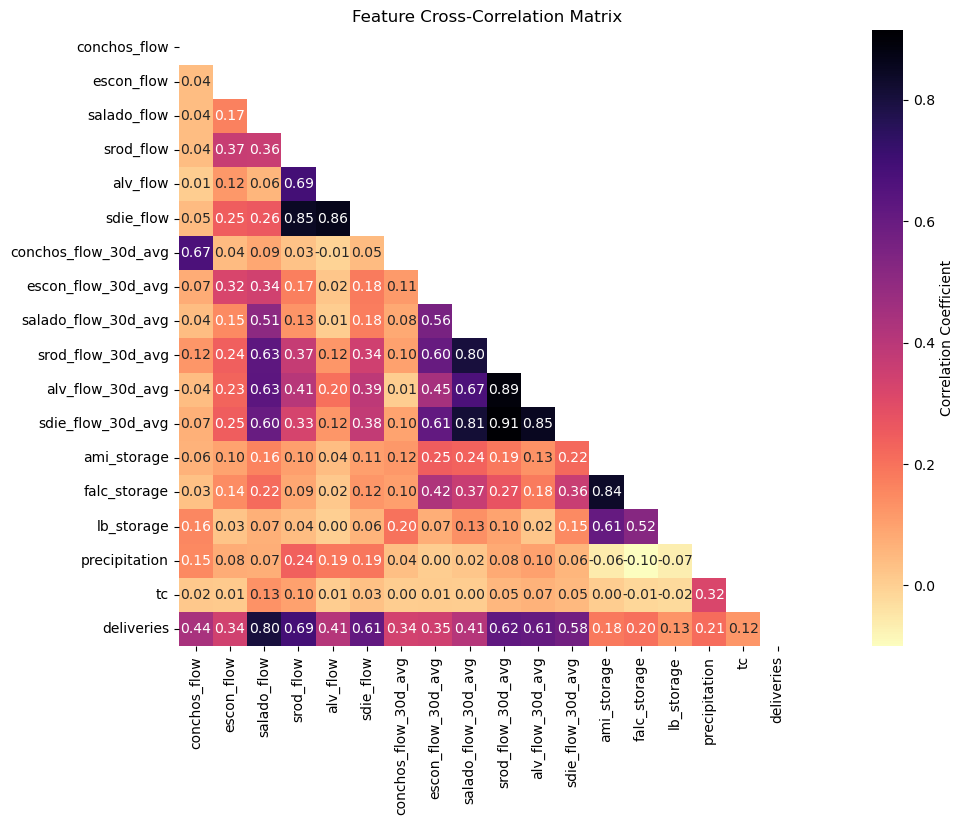

In [190]:
# Select the columns of interest

variables_of_interest = ['conchos_flow','escon_flow','salado_flow','srod_flow','alv_flow','sdie_flow',
                         'conchos_flow_30d_avg','escon_flow_30d_avg','salado_flow_30d_avg','srod_flow_30d_avg','alv_flow_30d_avg','sdie_flow_30d_avg',
                         'ami_storage','falc_storage','lb_storage','precipitation','tc','deliveries']

# Calculate the pairwise correlation matrix
correlation_matrix = df[variables_of_interest].corr()
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(20, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='magma_r', fmt='.2f', 
            cbar_kws={'label': 'Correlation Coefficient'}, square=True,mask=mask)

plt.title('Feature Cross-Correlation Matrix')

Training Persistence Model
Training Random Forest Model
Random Forest Complete
Training XGBoost Model
XGBoost Complete
Plotting Results
plotting
Plotting Correlation
Shapley Values for Random Forest Model
Shapley Values for XGBoost Model


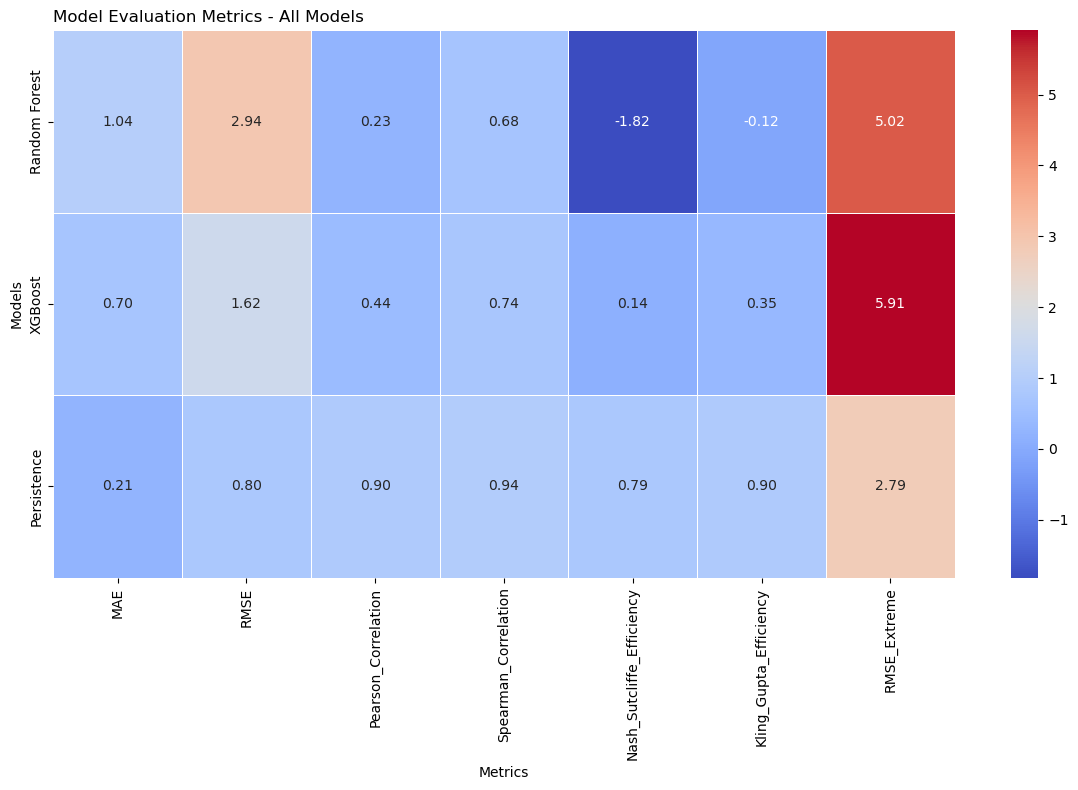

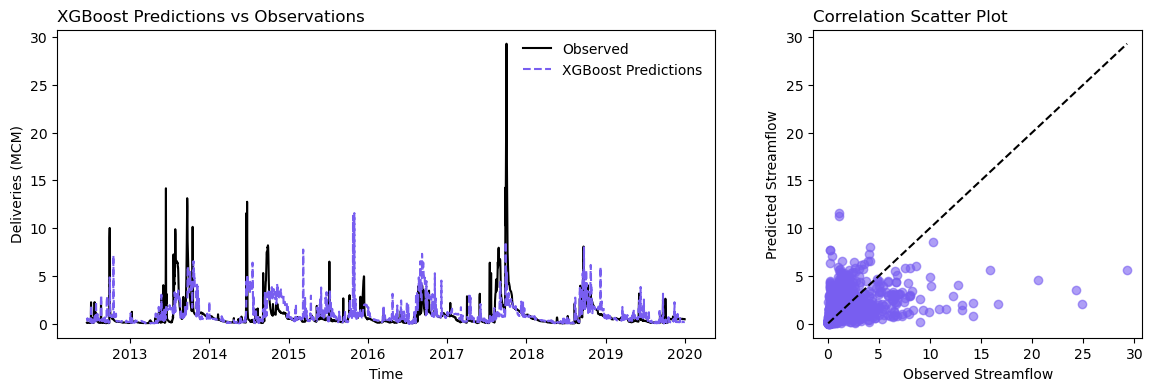

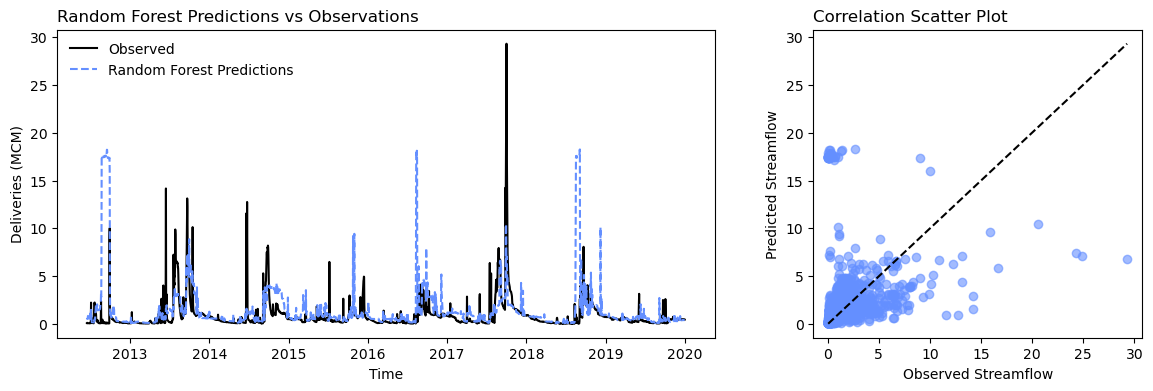

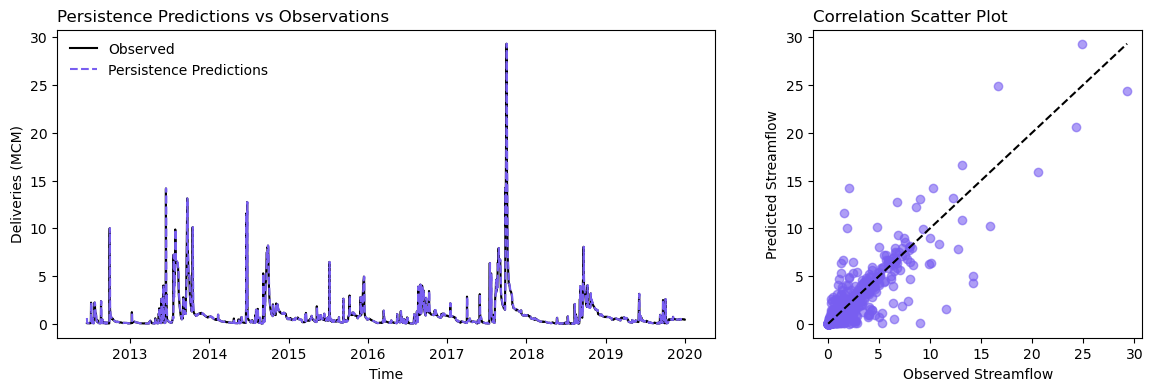

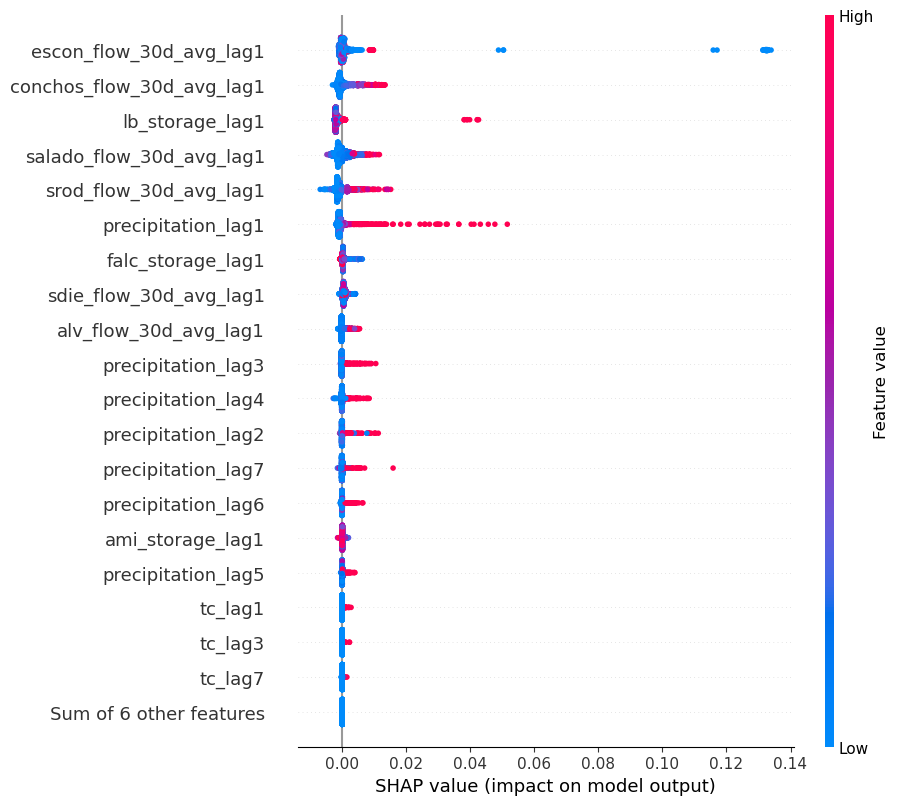

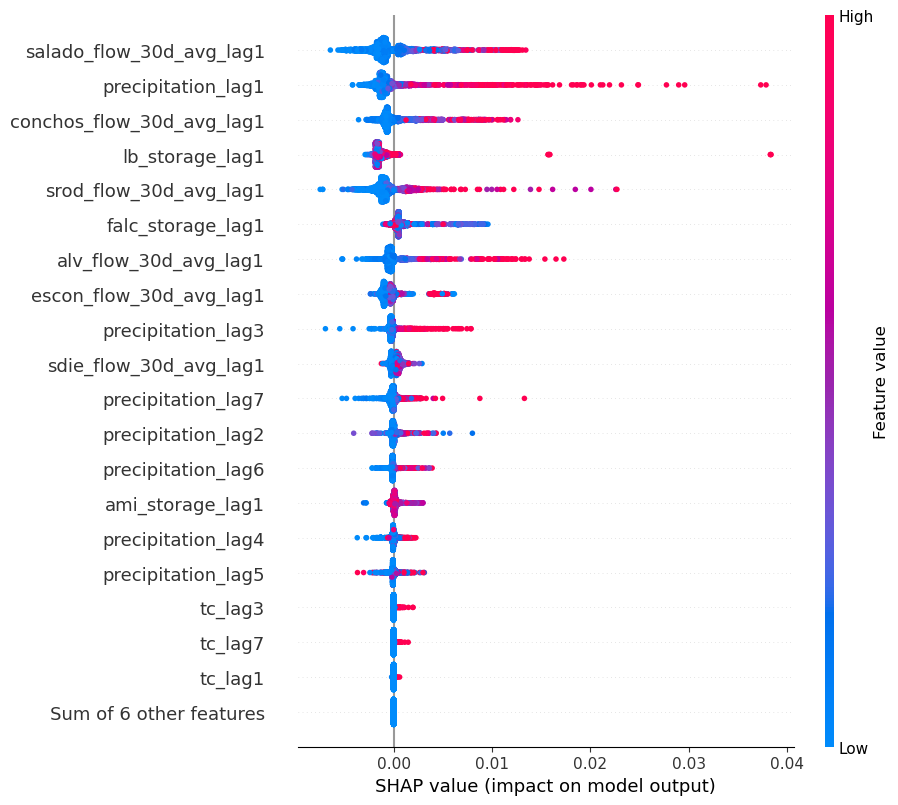

In [311]:
full_routine(lags_dict,df)

### BUILD MODELS

In [294]:
# Training and testing data for the deep learning models
X_train_seq, X_val_seq, X_test_seq, y_train_seq, y_val_seq, y_test_seq, denorm_dict_seq, dates_dict_seq, feature_cols_seq = process_data(
    df, lookback_period=lookback_period, lag_dict=lags_dict, trainyrs=9, valyrs=2,debug=1,target_column='deliveries')

# Training and testing data for the tree models
X_train_xg, X_val_xg, X_test_xg, y_train_xg, y_val_xg, y_test_xg, denorm_dict_xg, dates_dict_xg, feature_names_xg = process_data_for_xgboost(
    df,target_column='deliveries', lag_dict=lags_dict, debug=0,trainyrs=10, valyrs=2)

In [ ]:
def quantile_loss(q, y_true, y_pred):
    # Calculate the error
    error = y_true - y_pred
    # Compute quantile loss for the given quantile q
    loss = K.mean(K.maximum(q * error, (q - 1) * error), axis=-1)
    return loss

In [68]:
### Define Models
### LSTM MODEL ###
lstm_model = Sequential([
    LSTM(128, activation='tanh',kernel_regularizer=l2(0.07), return_sequences=True, input_shape=(lookback_period, X_train_seq.shape[2])),
    Dropout(0.6),
    LSTM(64, activation='tanh'),
    Dropout(0.6),
    Dense(1)
])
lstm_model.compile(loss=Huber(delta=1.5), optimizer=Adam(), metrics=['mae'])


In [69]:
### GRU MODEL ###
gru_model = Sequential([
    GRU(128, activation='tanh',kernel_regularizer=l2(0.07), return_sequences=True, input_shape=(lookback_period, X_train_seq.shape[2])),
    Dropout(0.6),
    GRU(64, activation='tanh'),
    Dropout(0.6),
    Dense(1)
])
gru_model.compile(loss=Huber(delta=1.5), optimizer=Adam(), metrics=['mean_absolute_error'])

In [194]:
param_distributions = {
    'n_estimators': [100, 500, 1000, 1500],
    'learning_rate': [0.005, 0.01, 0.03, 0.1],
    'max_depth': [6, 8, 10, 12],
    'min_child_weight': [1, 2, 3, 4],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0.1, 0.4, 0.6, 1.0],
    'reg_lambda': [0.8, 1.0, 1.2, 1.5],
    'objective': ['reg:quantileerror'],  # Quantile regression objective
    'quantile_alpha': [0.95, 0.99, 0.995, 0.999],
}

# Initialize the XGBRegressor
xgb_model = XGBRegressor()

# Set up RandomizedSearchCV with the parameter grid
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings sampled
    cv=5,
    verbose=False,
    n_jobs=-1,
    random_state=42
)

# Fit the model to the training data
random_search.fit(X_train_xg, y_train_xg)

# Get the best hyperparameters
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the final model with the best hyperparameters
best_xgb_model = random_search.best_estimator_


Best parameters found: {'subsample': 0.8, 'reg_lambda': 1.0, 'reg_alpha': 0.4, 'quantile_alpha': 0.95, 'objective': 'reg:quantileerror', 'n_estimators': 1500, 'min_child_weight': 3, 'max_depth': 12, 'learning_rate': 0.03, 'colsample_bytree': 0.6}


In [192]:
rf_model = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)

### EVALUTE MODELS

In [74]:
# Evaluate the persistence model
persistence_preds, persistence_y_test, persistence_metrics = evaluate_persistence_model(y_train_xg, y_test_xg, denorm_dict_xg)

In [75]:
# Evaluate LSTM MODEL
lstm_history, lstm_preds, y_test_denorm_lstm, lstm_metrics = train_evaluate_sequential(
    lstm_model, X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq, denorm_dict_seq)
#lstm_model.save('lstm_model.keras')

Epoch 1/20
92/92 [==============================] - 30s 310ms/step - loss: 1.3385 - mae: 0.3153 - val_loss: 0.2165 - val_mae: 0.1855
Epoch 2/20
92/92 [==============================] - 29s 314ms/step - loss: 0.2267 - mae: 0.2461 - val_loss: 0.0702 - val_mae: 0.1913
Epoch 3/20
92/92 [==============================] - 29s 318ms/step - loss: 0.1757 - mae: 0.2401 - val_loss: 0.0579 - val_mae: 0.1549
Epoch 4/20
92/92 [==============================] - 28s 307ms/step - loss: 0.1709 - mae: 0.2406 - val_loss: 0.0454 - val_mae: 0.1219
Epoch 5/20
92/92 [==============================] - 29s 315ms/step - loss: 0.1579 - mae: 0.2228 - val_loss: 0.0538 - val_mae: 0.2002
Epoch 6/20
92/92 [==============================] - 28s 306ms/step - loss: 0.1444 - mae: 0.2141 - val_loss: 0.0482 - val_mae: 0.1650
Epoch 7/20
92/92 [==============================] - 27s 295ms/step - loss: 0.1431 - mae: 0.2153 - val_loss: 0.0456 - val_mae: 0.1355
Epoch 8/20
92/92 [==============================] - 27s 292ms/step - 

In [77]:
# EVALUATE GRU MODEL
gru_history, gru_preds, y_test_denorm_gru, gru_metrics = train_evaluate_sequential(
    gru_model, X_train_seq, y_train_seq, X_val_seq, y_val_seq, X_test_seq, y_test_seq, denorm_dict_seq
)

#gru_model.save('gru_model.keras')

Epoch 1/20
92/92 [==============================] - 25s 254ms/step - loss: 0.2184 - mean_absolute_error: 0.3546 - val_loss: 0.0331 - val_mean_absolute_error: 0.1281
Epoch 2/20
92/92 [==============================] - 23s 246ms/step - loss: 0.1609 - mean_absolute_error: 0.2885 - val_loss: 0.0244 - val_mean_absolute_error: 0.1260
Epoch 3/20
92/92 [==============================] - 23s 246ms/step - loss: 0.1340 - mean_absolute_error: 0.2576 - val_loss: 0.0198 - val_mean_absolute_error: 0.1187
Epoch 4/20
92/92 [==============================] - 23s 247ms/step - loss: 0.1223 - mean_absolute_error: 0.2448 - val_loss: 0.0203 - val_mean_absolute_error: 0.1204
Epoch 5/20
92/92 [==============================] - 23s 250ms/step - loss: 0.1067 - mean_absolute_error: 0.2217 - val_loss: 0.0191 - val_mean_absolute_error: 0.1085
Epoch 6/20
92/92 [==============================] - 23s 246ms/step - loss: 0.1056 - mean_absolute_error: 0.2201 - val_loss: 0.0204 - val_mean_absolute_error: 0.1285
Epoch 7/20

In [173]:
# EVALUATE RANDOM FOREST
rf_model, rf_predictions, rf_y_test, rf_metrics = evaluate_rf_model(
    rf_model, X_train_xg, y_train_xg, X_val_xg, y_val_xg, X_test_xg, y_test_xg, denorm_dict_xg
)

/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


In [195]:
# EVALUATE XGBOOST
xgb_model, best_xgb_preds, denorm_y_test_xg, metrics_xgb = train_evaluate_xgboost_model(
    best_xgb_model, X_train_xg, y_train_xg, X_val_xg, y_val_xg, X_test_xg, y_test_xg, denorm_dict_xg
)

/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


### RESULTS

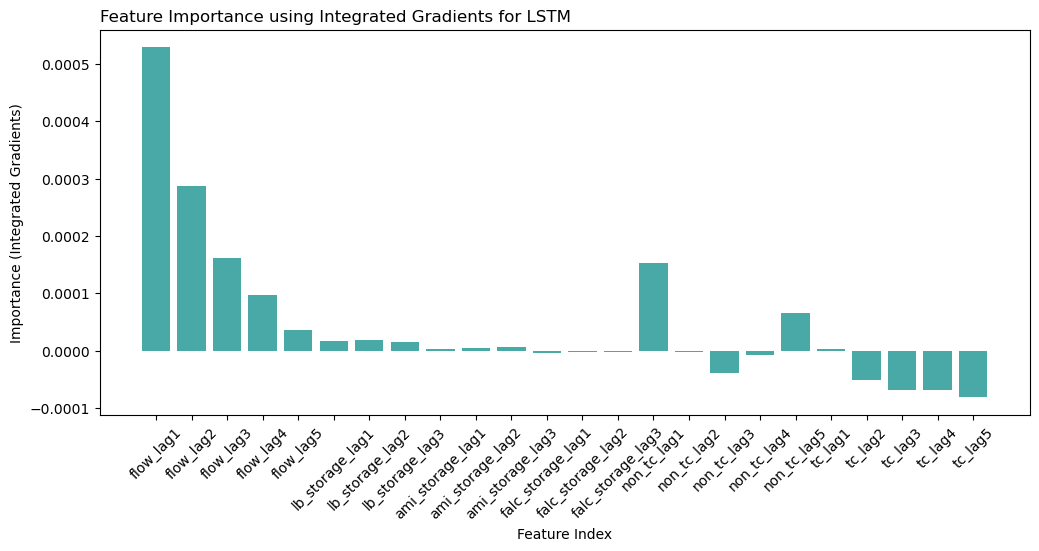

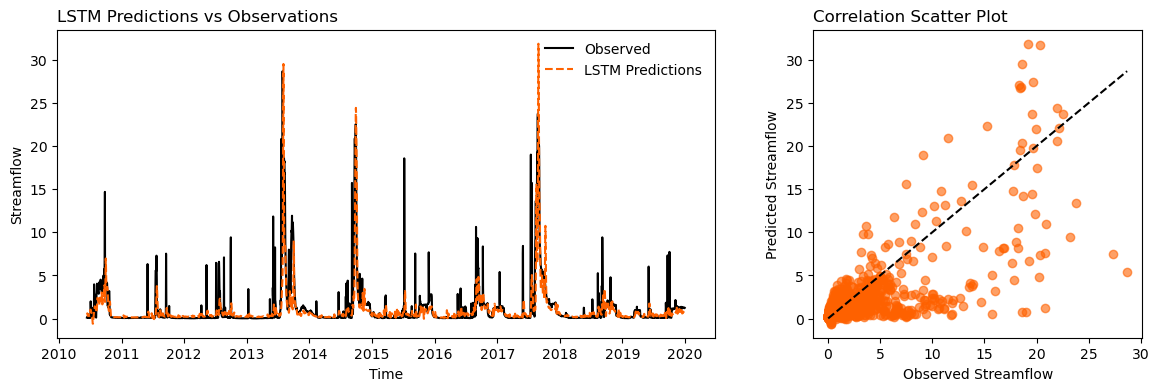

In [105]:
### LSTM
plot_integrated_grads(X_test_seq,features_lstm,lstm_model,'LSTM')
plot_predictions(y_test_denorm,lstm_preds,'LSTM',color=IBM_ORANGE)

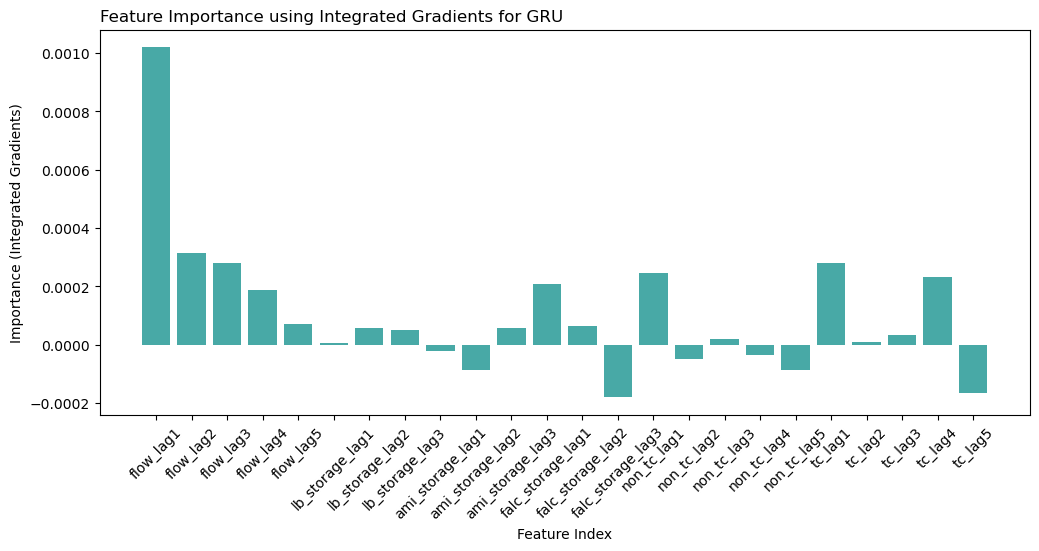

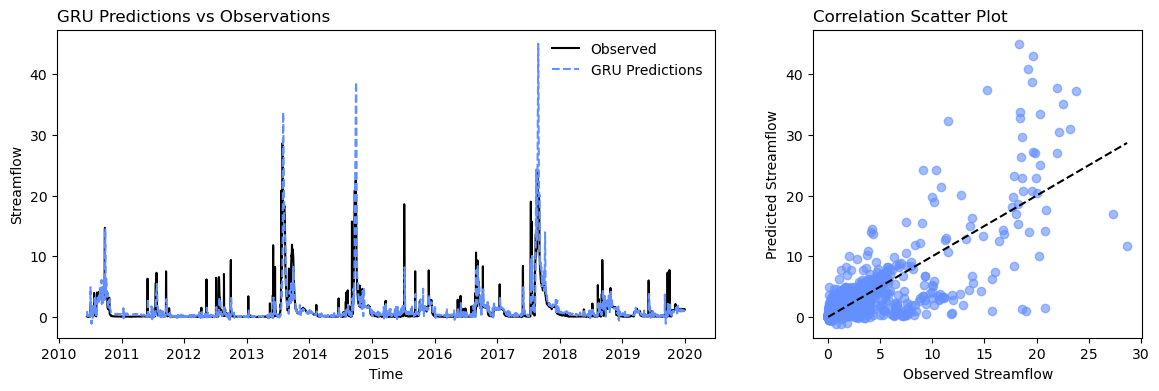

In [106]:
### GRU
plot_integrated_grads(X_test_seq,features_lstm,gru_model,'GRU')
plot_predictions(y_test_denorm_gru,gru_preds,'GRU',color=IBM_BLUE)

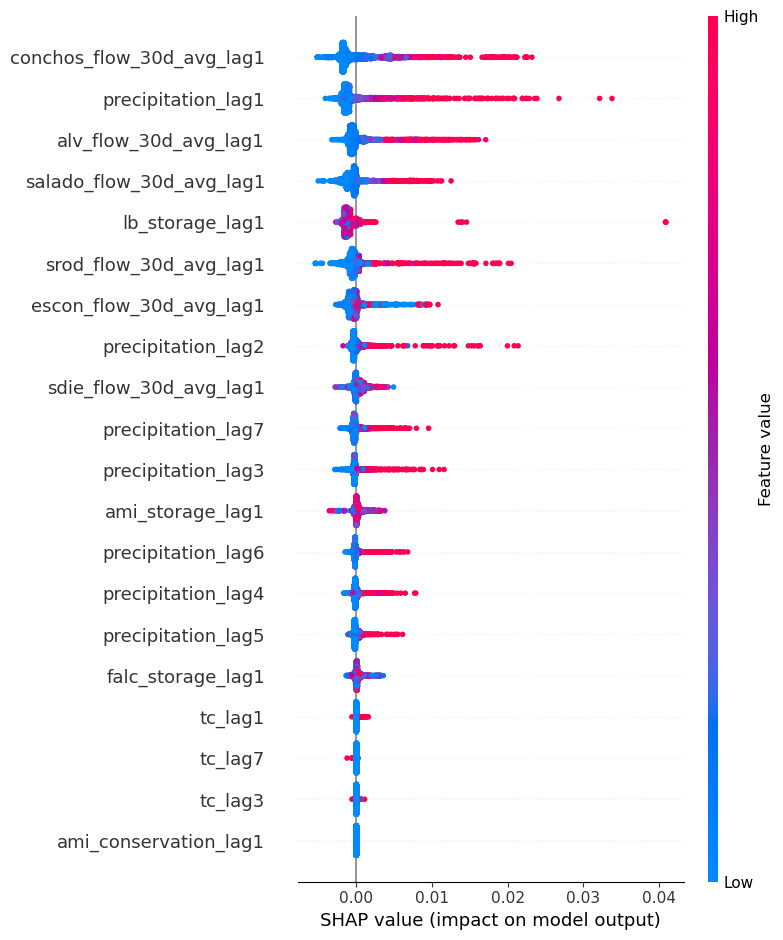

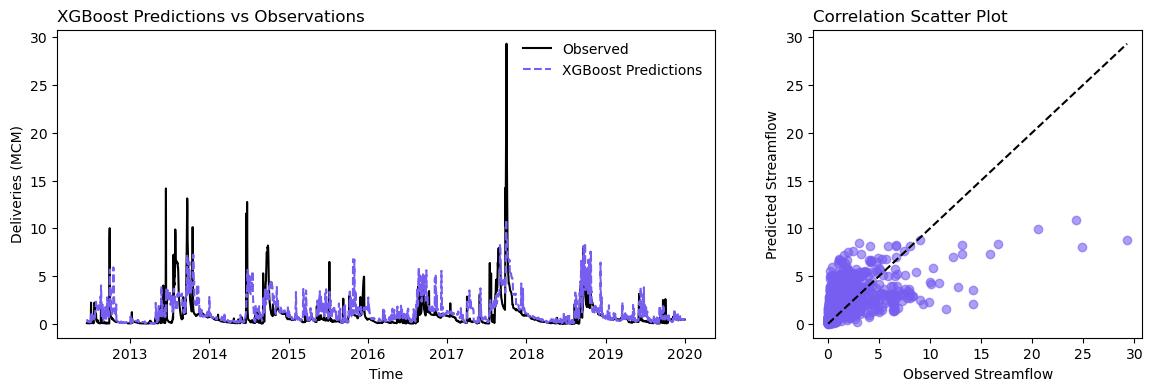

In [196]:
### XGBOOST
explainer = shap.Explainer(best_xgb_model)
shap_values = explainer(X_test_xg)

# Summary plot with feature names
shap.summary_plot(shap_values, X_test_xg, feature_names=feature_names_xg)

plot_predictions(denorm_y_test_xg,best_xgb_preds,'XGBoost',color=IBM_PURPLE,dates=dates_dict_xg)

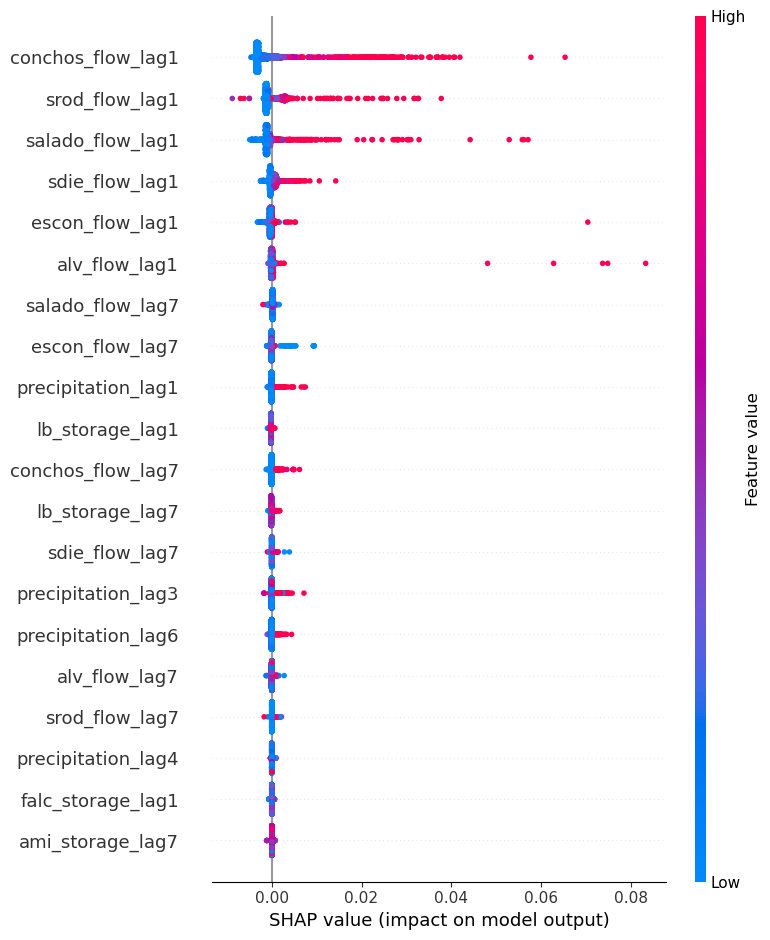

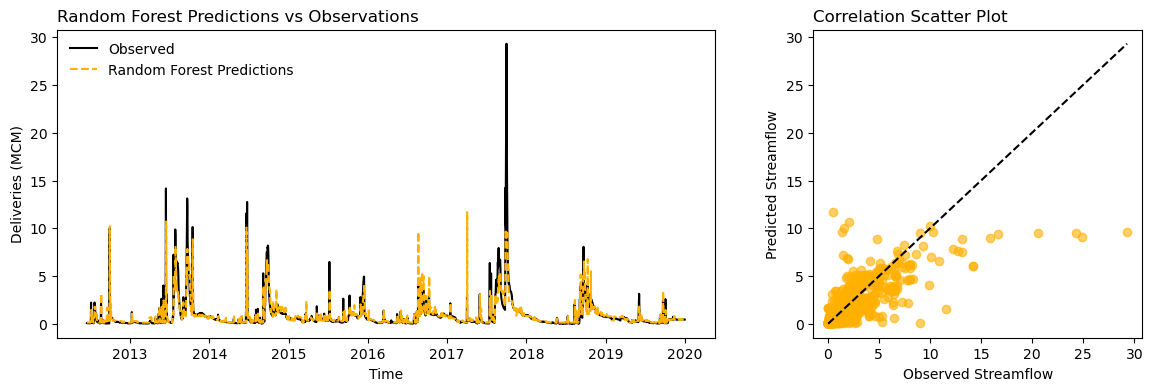

In [175]:
### RANDOM FOREST
explainer = shap.Explainer(rf_model)
shap_values = explainer(X_test_xg)

# Summary plot with feature names
shap.summary_plot(shap_values, X_test_xg, feature_names=feature_names_xg)

plot_predictions(rf_y_test,rf_predictions,'Random Forest',color=IBM_YELLOW,dates=dates_dict_xg)

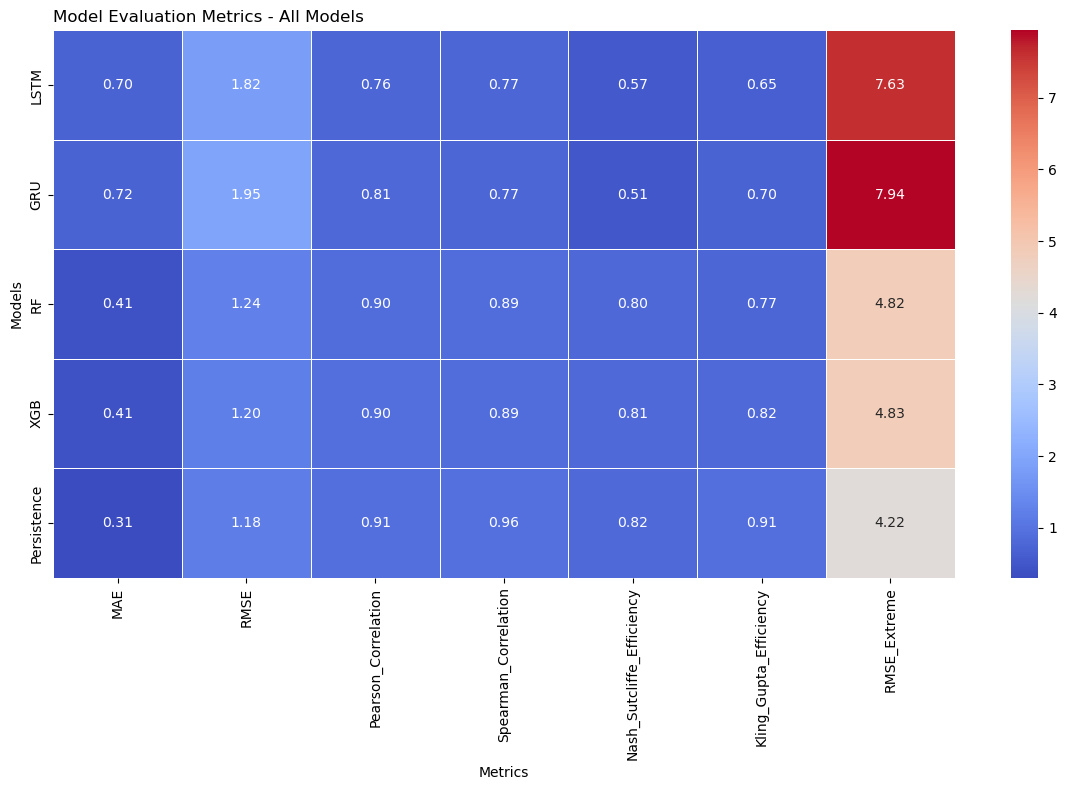

In [120]:
model_metrics = [lstm_metrics, gru_metrics, rf_metrics, metrics_xgb, persistence_metrics]

# Define model names
model_names = ['LSTM', 'GRU', 'RF', 'XGB', 'Persistence']

# Create a DataFrame from the dictionaries
metrics_df = pd.DataFrame(model_metrics, index=model_names)

# Create a heatmap
#plt.figure(figsize=(10, 6))
fig, ax = plt.subplots(1,1,figsize=(12,8))
sns.heatmap(metrics_df, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, linewidths=0.5)

# Customize the plot
ax.set_title('Model Evaluation Metrics - All Models',loc='left')
ax.set_ylabel('Models')
ax.set_xlabel('Metrics')

# Show the plot
fig.tight_layout()

### EXTRA

In [398]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

# Define the parameter grid to search, including the `alpha` for quantile regression
param_distributions = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.03, 0.1],
    'max_depth': [4, 6, 8],
    'min_child_weight': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.4, 1.0],
    'reg_lambda': [0.8, 1.0, 1.2],
    'objective': ['reg:quantileerror'],  # Quantile regression objective
    'quantile_alpha': [0.7,0.9,0.95,0.99]  # Quantile parameter (0.9 for 90th percentile, change as needed)
}

# Initialize the XGBRegressor
xgb_model = XGBRegressor()

# Set up RandomizedSearchCV with the parameter grid
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings sampled
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Fit the model to the training data
random_search.fit(X_train_xg, y_train_xg)

# Get the best hyperparameters
best_params = random_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the final model with the best hyperparameters
best_xgb_model = random_search.best_estimator_

# Evaluate the final model (assuming train_evaluate_xgboost_model is defined)
xgb_model, best_xgb_preds, denorm_y_test_xg, metrics_xgb = train_evaluate_xgboost_model(
    best_xgb_model, X_train_xg, y_train_xg, X_val_xg, y_val_xg, X_test_xg, y_test_xg, denorm_dict_xg
)

# Print the metrics
for metric, value in metrics_xgb.items():
    print(f"{metric}: {value}")


Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best parameters found: {'subsample': 1.0, 'reg_lambda': 1.2, 'reg_alpha': 1.0, 'quantile_alpha': 0.9, 'objective': 'reg:quantileerror', 'n_estimators': 1000, 'min_child_weight': 2, 'max_depth': 8, 'learning_rate': 0.01, 'colsample_bytree': 1.0}
[0]	validation_0-quantile:0.07389
[1]	validation_0-quantile:0.06954
[2]	validation_0-quantile:0.06338
[3]	validation_0-quantile:0.05785
[4]	validation_0-quantile:0.05362
[5]	validation_0-quantile:0.04936
[6]	validation_0-quantile:0.04525
[7]	validation_0-quantile:0.04013
[8]	validation_0-quantile:0.03585
[9]	validation_0-quantile:0.03525
[10]	validation_0-quantile:0.03483
[11]	validation_0-quantile:0.03470
[12]	validation_0-quantile:0.03457
[13]	validation_0-quantile:0.03453
[14]	validation_0-quantile:0.03439
[15]	validation_0-quantile:0.03428
[16]	validation_0-quantile:0.03410
[17]	validation_0-quantile:0.03395
[18]	validation_0-quantile:0.03383
[19]	validation_0-quantile:0.03364
[2

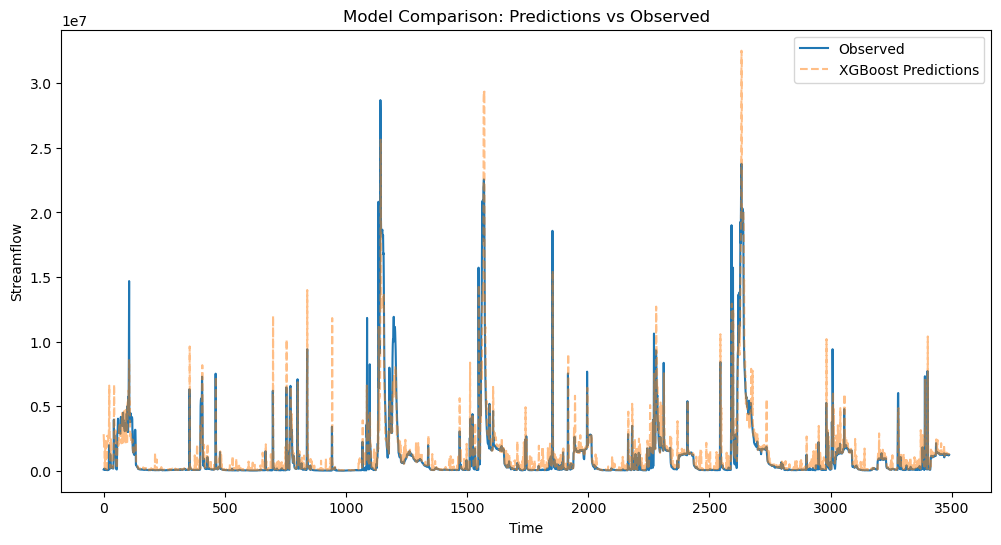

In [401]:
### Plot Results
plt.figure(figsize=(12, 6))
plt.plot(y_test_denorm, label='Observed')
#plt.plot(lstm_preds, label='LSTM Predictions', linestyle='--')
plt.plot(best_xgb_preds, label='XGBoost Predictions', linestyle='--',alpha=0.5)
#plt.plot(gru_preds, label='GRU Predictions', linestyle='--')
#plt.plot(persistence_preds, label='Persistence Predictions', linestyle='-')
plt.legend()
plt.title('Model Comparison: Predictions vs Observed')
plt.ylabel('Streamflow')
plt.xlabel('Time')
plt.show()

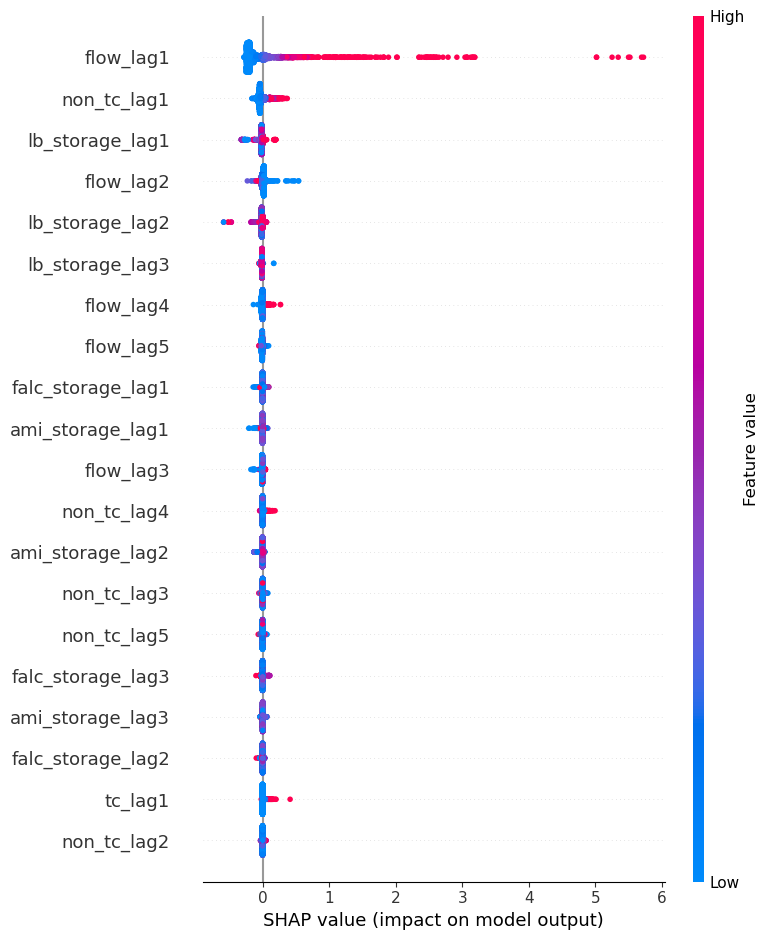

In [402]:
import shap
# Use the SHAP explainer
explainer = shap.Explainer(best_xgb_model)
shap_values = explainer(X_test_xg)

# Summary plot with feature names
shap.summary_plot(shap_values, X_test_xg, feature_names=features_lstm)

# Force plot for an individual prediction (adjust the index for a specific instance)
instance_index = 1050
shap.force_plot(explainer.expected_value, shap_values.values[instance_index], X_test_xg[instance_index], feature_names=features_lstm)

In [407]:
print(f'lstm_metrics: {lstm_metrics}')
print(f'gru_metrics: {gru_metrics}')
print(f'rf_metrics: {rf_metrics}')
print(f'metrics_xgb: {metrics_xgb}')
print(f'persistence_metrics: {persistence_metrics}')

lstm_metrics: {'MAE': 706386.2114906877, 'RMSE': 1784048.4389406382, 'Pearson_Correlation': 0.7795205078593276, 'Spearman_Correlation': 0.7385903346688286, 'Nash_Sutcliffe_Efficiency': 0.5872534965691734, 'Kling_Gupta_Efficiency': 0.6250103636568036, 'RMSE_Extreme': 7277674.594059642}
gru_metrics: {'MAE': 792628.8532041546, 'RMSE': 1874667.106319894, 'Pearson_Correlation': 0.8000656699425824, 'Spearman_Correlation': 0.7677284601360469, 'Nash_Sutcliffe_Efficiency': 0.5442586467660218, 'Kling_Gupta_Efficiency': 0.7115348311486178, 'RMSE_Extreme': 6787947.605253144}
rf_metrics: {'MAE': 407707.6995767738, 'RMSE': 1250038.658438315, 'Pearson_Correlation': 0.8994524830695838, 'Spearman_Correlation': 0.8940318684754288, 'Nash_Sutcliffe_Efficiency': 0.7973638117191015, 'Kling_Gupta_Efficiency': 0.7633119512223567, 'RMSE_Extreme': 4864084.649765655}
metrics_xgb: {'MAE': 569534.4924061605, 'RMSE': 1414932.66934115, 'Pearson_Correlation': 0.8645848804428959, 'Spearman_Correlation': 0.840733300648

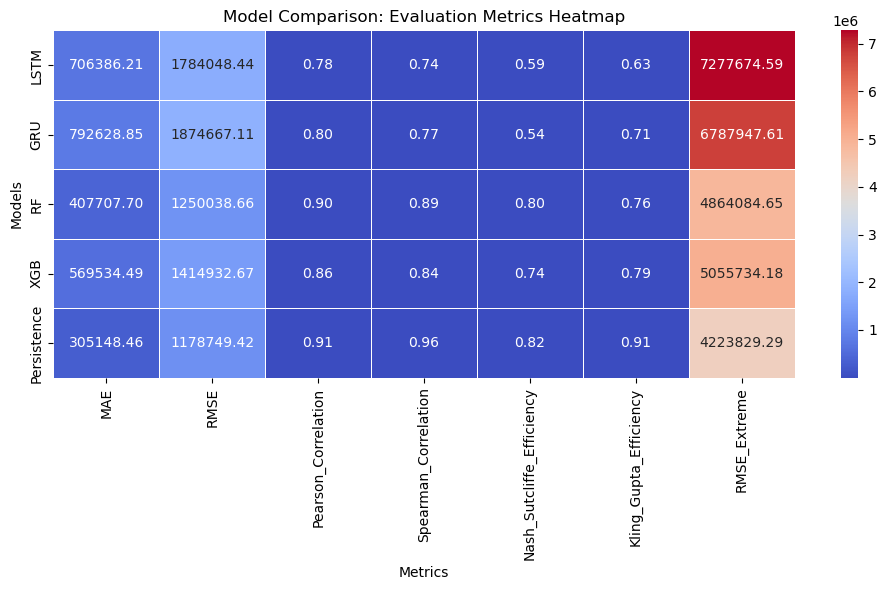

In [432]:
import seaborn as sns
model_metrics = [lstm_metrics, gru_metrics, rf_metrics, metrics_xgb, persistence_metrics]

# Define model names
model_names = ['LSTM', 'GRU', 'RF', 'XGB', 'Persistence']

# Create a DataFrame from the dictionaries
metrics_df = pd.DataFrame(model_metrics, index=model_names)

# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(metrics_df, annot=True, cmap='coolwarm', fmt=".2f", cbar=True, linewidths=0.5)

# Customize the plot
plt.title('Model Comparison: Evaluation Metrics Heatmap')
plt.ylabel('Models')
plt.xlabel('Metrics')

# Show the plot
plt.tight_layout()

In [59]:
dates_dict_xg['test_dates']

{'train_dates': 5      2000-06-06
 6      2000-06-07
 7      2000-06-08
 8      2000-06-09
 9      2000-06-10
           ...    
 3293   2009-06-07
 3294   2009-06-08
 3295   2009-06-09
 3296   2009-06-10
 3297   2009-06-11
 Name: date, Length: 3293, dtype: datetime64[ns],
 'val_dates': 3298   2009-06-12
 3299   2009-06-13
 3300   2009-06-14
 3301   2009-06-15
 3302   2009-06-16
           ...    
 3658   2010-06-07
 3659   2010-06-08
 3660   2010-06-09
 3661   2010-06-10
 3662   2010-06-11
 Name: date, Length: 365, dtype: datetime64[ns],
 'test_dates': 3663   2010-06-12
 3664   2010-06-13
 3665   2010-06-14
 3666   2010-06-15
 3667   2010-06-16
           ...    
 7148   2019-12-27
 7149   2019-12-28
 7150   2019-12-29
 7151   2019-12-30
 7152   2019-12-31
 Name: date, Length: 3490, dtype: datetime64[ns]}